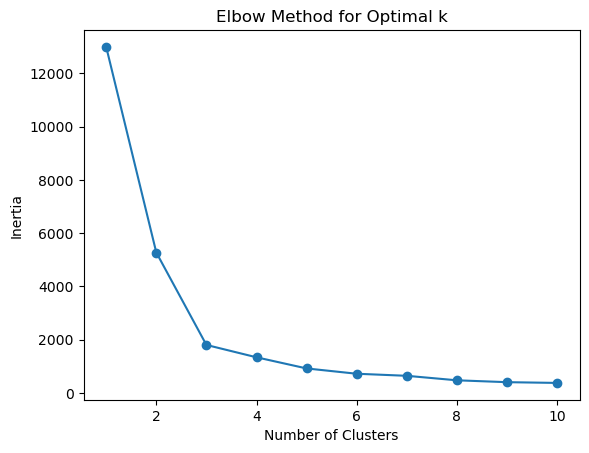

In [10]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np


# Load the cleaned dataset
df = pd.read_excel("../data/cleaned_retail.xlsx", engine="openpyxl")

# Filter out cancelled transactions
df['IsCancelled'] = df['CancellationFlag'].notnull() & (df['CancellationFlag'].astype(str).str.strip() != '')
df_clean = df[~df['IsCancelled']]

customer_df = df_clean.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',       # Frequency
    'Subtotal': 'sum',            # Monetary
    'InvoiceDate': 'max'          # Last purchase date
}).rename(columns={
    'InvoiceNo': 'Frequency',
    'Subtotal': 'Monetary',
    'InvoiceDate': 'LastPurchase'
})

# Recency: days since last purchase
latest_date = df_clean['InvoiceDate'].max()
customer_df['Recency'] = (latest_date - customer_df['LastPurchase']).dt.days
customer_df.drop(columns='LastPurchase', inplace=True)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_df[['Recency', 'Frequency', 'Monetary']])

inertia = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled_features)
    inertia.append(model.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


- Interpretation: 3 clusters likely capture the major behavioral groups without overfitting

In [11]:
kmeans = KMeans(n_clusters=3, random_state=4)
customer_df['Cluster'] = kmeans.fit_predict(scaled_features)

In [12]:
customer_df['AvgOrderValue'] = customer_df['Monetary'] / customer_df['Frequency']
customer_df['RecencyCategory'] = pd.cut(customer_df['Recency'], bins=[-1, 30, 90, 180, 9999],
                                        labels=['Recent', 'Warm', 'Cool', 'Dormant'])

In [13]:
# Hard to see cluster with 3 variables so instead of plotting with the code below we decided to move to PCA
# sns.set(style="whitegrid", palette="Set2", font_scale=1.2)

# # Define metrics to plot
# metrics = ['Monetary', 'Frequency', 'AvgOrderValue']
# fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6))

# for i, metric in enumerate(metrics):
#     sns.boxplot(data=customer_df, x='Cluster', y=metric, ax=axes[i])
#     axes[i].set_title(f'{metric} by Cluster', fontsize=14, fontweight='bold')
#     axes[i].set_xlabel('Cluster')
#     axes[i].set_ylabel(metric)
#     axes[i].grid(True, linestyle='--', alpha=0.6)

# plt.tight_layout()
# plt.show()



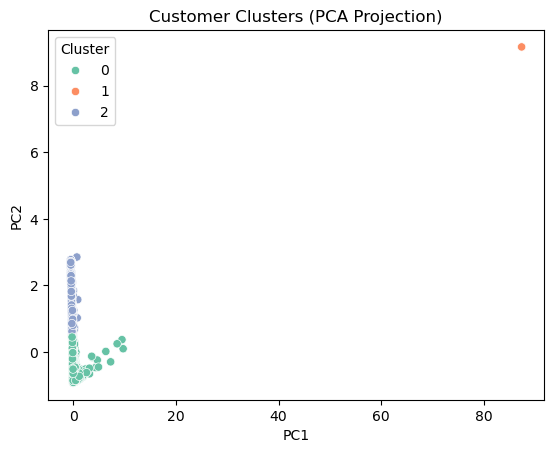

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
customer_df['PC1'] = pca_components[:, 0]
customer_df['PC2'] = pca_components[:, 1]

sns.scatterplot(data=customer_df, x='PC1', y='PC2', hue='Cluster', palette='Set2')
plt.title('Customer Clusters (PCA Projection)')
plt.show()


📈 Why Use PCA for Clustering?
- Your clustering was done in 3D space (Recency, Frequency, Monetary), but that’s hard to visualize.
- PCA projects that 3D space into 2D, so you can see how clusters separate.
- Each dot in the PCA plot is a customer, and their position reflects their behavior compressed into PC1 and PC2.

🔍 How to Interpret Your PCA Plot
- Clusters: You’ve got three distinct groups (0, 1, 2), each colored differently.
- Spread: The distance between points shows how different customers are.
- Outliers: That one point far from the rest (around PC1 = 80) is likely a high-spending or high-frequency customer — they’re behaviorally unique.

🧩 What PC1 and PC2 Mean
- PC1 might represent a blend of Monetary + Frequency — customers who spend more and buy often.
- PC2 could capture Recency — how recently they purchased.
- These interpretations depend on how your features correlate, but PCA automatically finds the most “informative” directions


In [15]:
pca = PCA(n_components=2)
pca.fit(scaled_features)
print("PC1 weights:", np.round(pca.components_[0], 2))
print("PC2 weights:", np.round(pca.components_[1], 2))

PC1 weights: [-0.11  0.7   0.7 ]
PC2 weights: [0.99 0.05 0.11]


In [16]:
summary = customer_df.groupby('Cluster').agg({
    'Monetary': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'AvgOrderValue': ['mean', 'median']
}).round(2)
display(summary)


Monetary             Frequency         AvgOrderValue         
               mean      median      mean  median          mean   median
Cluster                                                                 
0           2453.62      921.07      5.12     3.0        397.65   308.74
1        1691524.48  1691524.48   1363.00  1363.0       1241.03  1241.03
2            573.96      311.13      1.60     1.0        346.38   232.54

In [17]:
customer_df.reset_index().to_excel("customer_segments.xlsx", index=False)

In [18]:
# Group by Cluster and RecencyCategory (if available)
pivot_table = customer_df.groupby(['Cluster', 'RecencyCategory']).agg({
    'Monetary': 'sum',
    'Frequency': 'mean'
}).reset_index()

pivot_table = pivot_table[pivot_table['Monetary'] > 0]

# Calculate total monetary for percentage column
total_monetary = pivot_table['Monetary'].sum()
pivot_table['MonetaryPct'] = (pivot_table['Monetary'] / total_monetary * 100).round(2)

# Rename columns for clarity
pivot_table.rename(columns={
    'Monetary': 'Sum of Monetary',
    'MonetaryPct': 'Sum of Monetary (%)',
    'Frequency': 'Average of Frequency'
}, inplace=True)

# Format and style for display
styled_pivot = pivot_table.style.set_caption("Pivot Summary: Customer Segments by Cluster and Recency") \
    .format({
        'Sum of Monetary': '{:,.2f}',
        'Sum of Monetary (%)': '{:.2f}%',
        'Average of Frequency': '{:,.2f}'
    }) 

styled_pivot

C:\Users\lmcr-\AppData\Local\Temp\ipykernel_10212\4267020566.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pivot_table = customer_df.groupby(['Cluster', 'RecencyCategory']).agg({


,Cluster,RecencyCategory,Sum of Monetary,Average of Frequency,Sum of Monetary (%)
0,0,Recent,"6,134,773.23",7.15,59.59%
1,0,Warm,"1,516,081.32",3.04,14.73%
2,0,Cool,"335,688.30",2.54,3.26%
4,1,Recent,"1,691,524.48","1,363.00",16.43%
10,2,Cool,"136,810.40",2.04,1.33%
11,2,Dormant,"479,621.52",1.50,4.66%


C:\Users\lmcr-\AppData\Local\Temp\ipykernel_10212\1857668401.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='Cluster', y=metric, ax=axes[i], palette='pastel')
C:\Users\lmcr-\AppData\Local\Temp\ipykernel_10212\1857668401.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='Cluster', y=metric, ax=axes[i], palette='pastel')
C:\Users\lmcr-\AppData\Local\Temp\ipykernel_10212\1857668401.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='Cluster', y=metric, ax=axes[i], palette='p

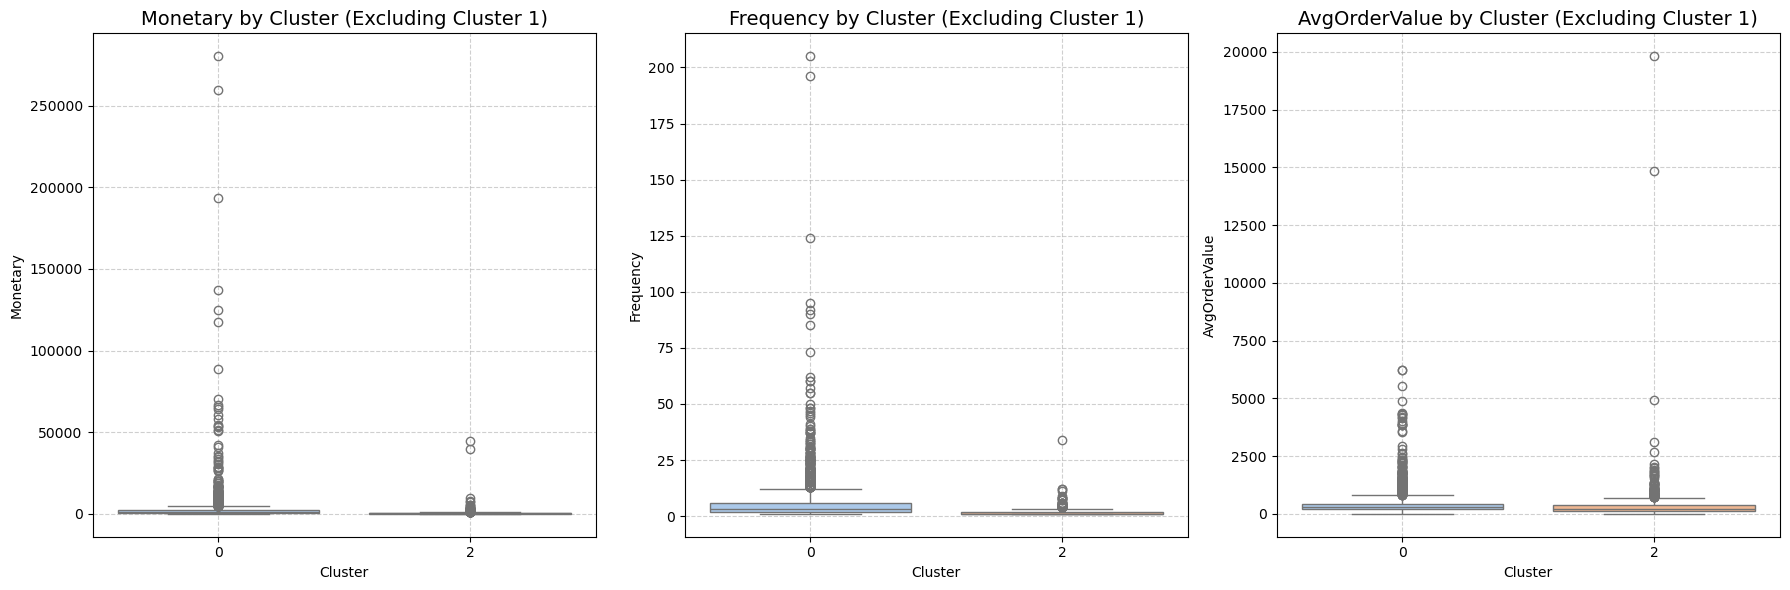

In [19]:
# Filter out Cluster 1
filtered_df = customer_df[customer_df['Cluster'] != 1]

# Define metrics to plot
metrics = ['Monetary', 'Frequency', 'AvgOrderValue']
fig, axes = plt.subplots(1, len(metrics), figsize=(18, 6))

# Create boxplots for each metric
for i, metric in enumerate(metrics):
    sns.boxplot(data=filtered_df, x='Cluster', y=metric, ax=axes[i], palette='pastel')
    axes[i].set_title(f'{metric} by Cluster (Excluding Cluster 1)', fontsize=14)
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(metric)
    axes[i].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### DBSCAN

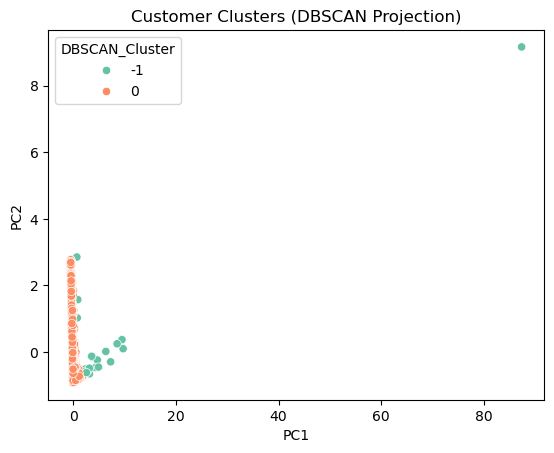

In [20]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Use PCA-reduced features or scaled RFM
scaled = StandardScaler().fit_transform(customer_df[['Recency', 'Frequency', 'Monetary']])

# Try DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_df['DBSCAN_Cluster'] = dbscan.fit_predict(scaled)

# Visualize with PCA
sns.scatterplot(data=customer_df, x='PC1', y='PC2', hue='DBSCAN_Cluster', palette='Set2')
plt.title('Customer Clusters (DBSCAN Projection)')
plt.show()

In [21]:
import pandas as pd
from sklearn.decomposition import PCA

# Assuming scaled_features is your standardized input (e.g., Recency, Frequency, Monetary)
# And feature_names is the list of original feature names
feature_names = ['Recency', 'Frequency', 'Monetary']

# Fit PCA
pca = PCA(n_components=2)
pca.fit(scaled_features)

# Create DataFrame of PCA loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=feature_names)

# Round for readability
loadings_rounded = loadings.round(3)

# Display the loadings
print("PCA Feature Loadings (Contribution of each feature to PC1 and PC2):")
print(loadings_rounded)


PCA Feature Loadings (Contribution of each feature to PC1 and PC2):
             PC1    PC2
Recency   -0.114  0.993
Frequency  0.704  0.055
Monetary   0.701  0.107


🧠 Interpretation
PC1: Customer Value Axis
- Dominated by Frequency (0.704) and Monetary (0.701)
- Represents overall customer value — how often and how much they spend
- Customers with high PC1 scores are frequent and high spenders
PC2: Engagement Recency Axis
- Almost entirely driven by Recency (0.993)
- Separates recent buyers from dormant ones
- High PC2 score → very recent purchase
- Low PC2 score → long time since last purchase

📈 Strategic Insight
- PC1 clusters likely reflect loyalty tiers (e.g., high-value vs low-value)
- PC2 clusters reflect timing — who’s active now vs who needs reactivation
- That outlier in your PCA plot (far right) probably has very high Frequency and Monetary, but low Recency — a dormant whale 
